## 1. Survey of BMI and physical activity
<p>We've all taken a survey at some point, but do you ever wonder what happens to your answers? Surveys are given to a carefully selected sample of people with the goal of generalizing the results to a much larger population.</p>
<p>The <a href="https://www.cdc.gov/nchs/nhanes/index.htm">National Health and Nutrition Examination Survey (NHANES)</a> data is a complex survey of tens of thousands of people designed to assess the health and nutritional status of adults and children in the United States. The NHANES data includes many measurements related to overall health, physical activity, diet, psychological health, socioeconomic factors and more.</p>
<p>Depending on the sampling design, each person has a sampling weight that quantifies how many people in the larger population their data is meant to represent. In this notebook, we'll apply survey methods that use sampling weights to estimate and model relationships between measurements.</p>
<p>We are going to focus on a common health indicator, Body Mass Index (<a href="https://en.wikipedia.org/wiki/Body_mass_index">BMI</a> kg/m<sup>2</sup>), and how it is related to physical activity. We'll visualize the data and use survey-weighted regression to test for associations.</p>
<p><img src="https://assets.datacamp.com/production/project_677/img/Activity-Flexibility-Wife-Women-Bending-Stretching-3098228.jpg" alt="activity"></p>

In [309]:
# Load the NHANES and dplyr packages
# .... YOUR CODE FOR TASK 1 ....
library(NHANES)
library(dplyr)
# Load the NHANESraw data
data(NHANESraw)

# Take a glimpse at the contents
# .... YOUR CODE FOR TASK 1 ....
glimpse(NHANESraw)

Observations: 20,293
Variables: 78
$ ID               <int> 51624, 51625, 51626, 51627, 51628, 51629, 51630, 5...
$ SurveyYr         <fct> 2009_10, 2009_10, 2009_10, 2009_10, 2009_10, 2009_...
$ Gender           <fct> male, male, male, male, female, male, female, fema...
$ Age              <int> 34, 4, 16, 10, 60, 26, 49, 1, 10, 80, 10, 80, 4, 3...
$ AgeMonths        <int> 409, 49, 202, 131, 722, 313, 596, 12, 124, NA, 121...
$ Race1            <fct> White, Other, Black, Black, Black, Mexican, White,...
$ Race3            <fct> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA...
$ Education        <fct> High School, NA, NA, NA, High School, 9 - 11th Gra...
$ MaritalStatus    <fct> Married, NA, NA, NA, Widowed, Married, LivePartner...
$ HHIncome         <fct> 25000-34999, 20000-24999, 45000-54999, 20000-24999...
$ HHIncomeMid      <int> 30000, 22500, 50000, 22500, 12500, 30000, 40000, 4...
$ Poverty          <dbl> 1.36, 1.07, 2.27, 0.81, 0.69, 1.01, 1.91, 1.36, 2....
$ HomeRooms      

## 2. Visualize survey weight and strata variables
<p>We see from <code>glimpse()</code> that the <code>NHANESraw</code> data has many health measurement variables. It also contains a sampling weight variable <code>WTMEC2YR</code>.</p>
<p>Since <code>NHANESraw</code> data spans 4 years (2009&ndash;2012) and the sampling weights are based on 2 years of data, we first need to create a weight variable that scales the sample across the full 4 years. We will divide the 2-year weight in half so that in total, the weights sum to the total US population.</p>
<p>The NHANES data has oversampled some geographic regions and specific minority groups. By examining the distribution of sampling weights for each race, we can see that Whites are undersampled and have higher weights while oversampled Black, Mexican, Hispanic people have lower weights since each sampled person in these minority groups represents fewer US people.</p>

sum(WTMEC4YR)
304267200


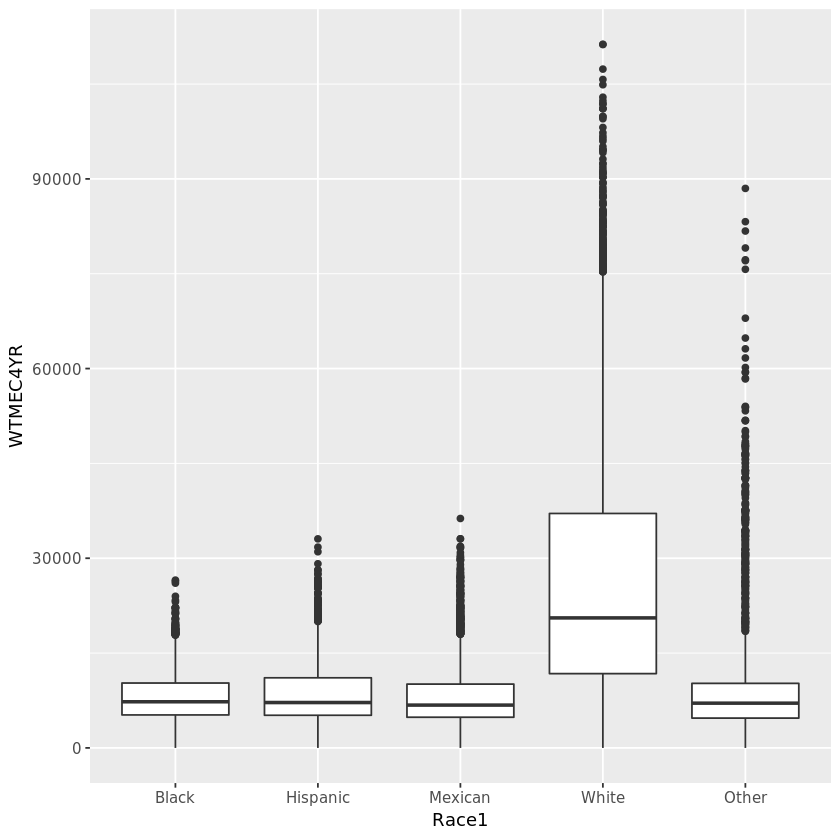

In [311]:
# Load the ggplot2 package
# .... YOUR CODE FOR TASK 2 ....
library(ggplot2)

# Use mutate to create a 4-year weight variable and call it WTMEC4YR
NHANESraw <- mutate(NHANESraw, WTMEC4YR = WTMEC2YR / 2)

# Calculate the sum of this weight variable
summarize(NHANESraw, sum(WTMEC4YR))

# Plot the sample weights using boxplots, with Race1 on the x-axis
# .... YOUR CODE FOR TASK 2 ....
ggplot(data = NHANESraw, aes(x = Race1, y = WTMEC4YR)) +
    geom_boxplot()

## 3. Specify the survey design
<p>We will now use the <code>survey</code> package to specify the complex survey design that we will use in later analyses. The <code>NHANESraw</code> data contains a strata variable <code>SDMVSTRA</code>, and a cluster id variable (also known as a primary sampling unit, PSU), <code>SDMVPSU</code>, that accounts for design effects of clustering. These clusters (PSUs) are nested within strata.</p>

In [313]:
# Load the survey package
# .... YOUR CODE FOR TASK 3 ....
library(survey)
# Specify the survey design
nhanes_design <- svydesign(
    data = NHANESraw,
    strata = ~SDMVSTRA,
    id = ~SDMVPSU,
    nest = TRUE,
    weights = ~WTMEC4YR)

# Print a summary of this design
# .... YOUR CODE FOR TASK 3 ....
summary(nhanes_design)

Stratified 1 - level Cluster Sampling design (with replacement)
With (62) clusters.
svydesign(data = NHANESraw, strata = ~SDMVSTRA, id = ~SDMVPSU, 
    nest = TRUE, weights = ~WTMEC4YR)
Probabilities:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
8.986e-06 5.664e-05 1.054e-04       Inf 1.721e-04       Inf 
Stratum Sizes: 
            75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
obs        803 785 823 829 696 751 696 724 713 683 592 946 598 647 251 862 998
design.PSU   2   2   2   2   2   2   2   2   2   2   2   3   2   2   2   3   3
actual.PSU   2   2   2   2   2   2   2   2   2   2   2   3   2   2   2   3   3
            92  93  94  95  96  97  98  99 100 101 102 103
obs        875 602 688 722 676 608 708 682 700 715 624 296
design.PSU   3   2   2   2   2   2   2   2   2   2   2   2
actual.PSU   3   2   2   2   2   2   2   2   2   2   2   2
Data variables:
 [1] "ID"               "SurveyYr"         "Gender"           "Age"             
 [5] "AgeMon

## 4. Subset the data
<p>Analysis of survey data requires careful consideration of the sampling design and weights at every step. Something as simple as filtering the data becomes complicated when weights are involved. </p>
<p>When we wish to examine a subset of the data (i.e. the subpopulation of adult Hispanics with diabetes, or pregnant women), we must explicitly specify this in the design. We cannot simply remove that subset of the data through filtering the raw data because the survey weights will no longer be correct and will not add up to the full US population.</p>
<p>BMI categories are different for children and young adults younger than 20 so we will subset the data to only analyze adults of at least 20 years of age.</p>

In [315]:
# Select adults of Age >= 20 with subset
nhanes_adult <- subset(nhanes_design, Age >= 20)

# Print a summary of this subset
# .... YOUR CODE FOR TASK 4 ....
summary(nhanes_adult)

# Compare the number of observations in the full data to the adult data
nrow(nhanes_design)
nrow(nhanes_adult)

Stratified 1 - level Cluster Sampling design (with replacement)
With (62) clusters.
subset(nhanes_design, Age >= 20)
Probabilities:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
8.986e-06 4.303e-05 8.107e-05       Inf 1.240e-04       Inf 
Stratum Sizes: 
            75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
obs        471 490 526 500 410 464 447 400 411 395 357 512 327 355 153 509 560
design.PSU   2   2   2   2   2   2   2   2   2   2   2   3   2   2   2   3   3
actual.PSU   2   2   2   2   2   2   2   2   2   2   2   3   2   2   2   3   3
            92  93  94  95  96  97  98  99 100 101 102 103
obs        483 376 368 454 362 315 414 409 377 460 308 165
design.PSU   3   2   2   2   2   2   2   2   2   2   2   2
actual.PSU   3   2   2   2   2   2   2   2   2   2   2   2
Data variables:
 [1] "ID"               "SurveyYr"         "Gender"           "Age"             
 [5] "AgeMonths"        "Race1"            "Race3"            "Education"       


[1] 20293

[1] 11778

## 5. Visualizing BMI
<p>We let <code>svydesign()</code> do its magic, but how does this help us learn about the full US population? With survey methods, we can use the sampling weights to estimate the true distributions of measurements within the entire population. This works for many statistics such as means, proportions, and standard deviations.</p>
<p>We'll use survey methods to estimate average BMI in the US adult population and also to draw a weighted histogram of the distribution.</p>

"mean(BMI, na.rm = TRUE)"
28.98217


      mean     SE
BMI 28.734 0.1235

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 547 rows containing non-finite values (stat_bin)."

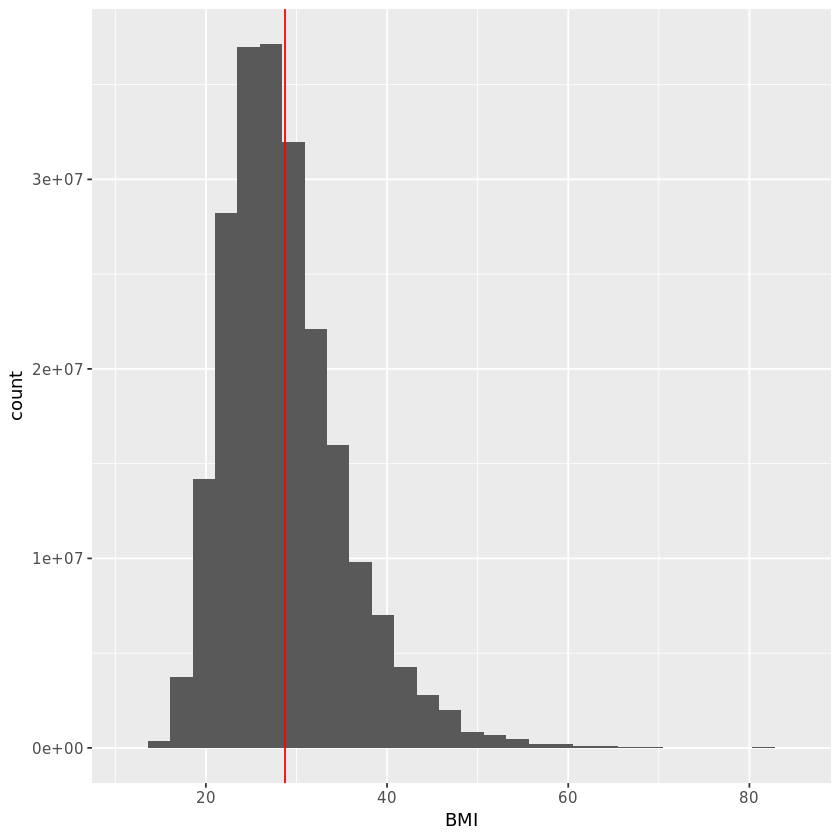

In [317]:
# Calculate the mean BMI in NHANESraw
bmi_mean_raw <- NHANESraw %>% 
    filter(Age >= 20) %>%
    summarize(mean(BMI, na.rm = TRUE))
bmi_mean_raw

# Calculate the survey-weighted mean BMI of US adults
bmi_mean <- svymean(~BMI, design = nhanes_adult, na.rm = TRUE)
bmi_mean

# Draw a weighted histogram of BMI in the US population
NHANESraw %>% 
  filter(Age >= 20) %>%
    ggplot(mapping = aes(BMI, weight = WTMEC4YR)) + 
    geom_histogram()+
    geom_vline(xintercept = coef(bmi_mean), color="red")


## 6. Is BMI lower in physically active people?
<p>The distribution of BMI looks to be about what we might expect with most people under 40 kg/m<sup>2</sup> and a slight positive skewness because a few people have much higher BMI. Now to the question of interest: does the distribution of BMI differ between people who are physically active versus those who are not physically active? We can visually compare BMI with a boxplot as well as formally test for a difference in mean BMI. </p>

Warning message:
"Removed 547 rows containing non-finite values (stat_boxplot)."

estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
-1.846458,-9.716503,4.56031e-11,32,-2.218916,-1.473999,Design-based t-test,two.sided


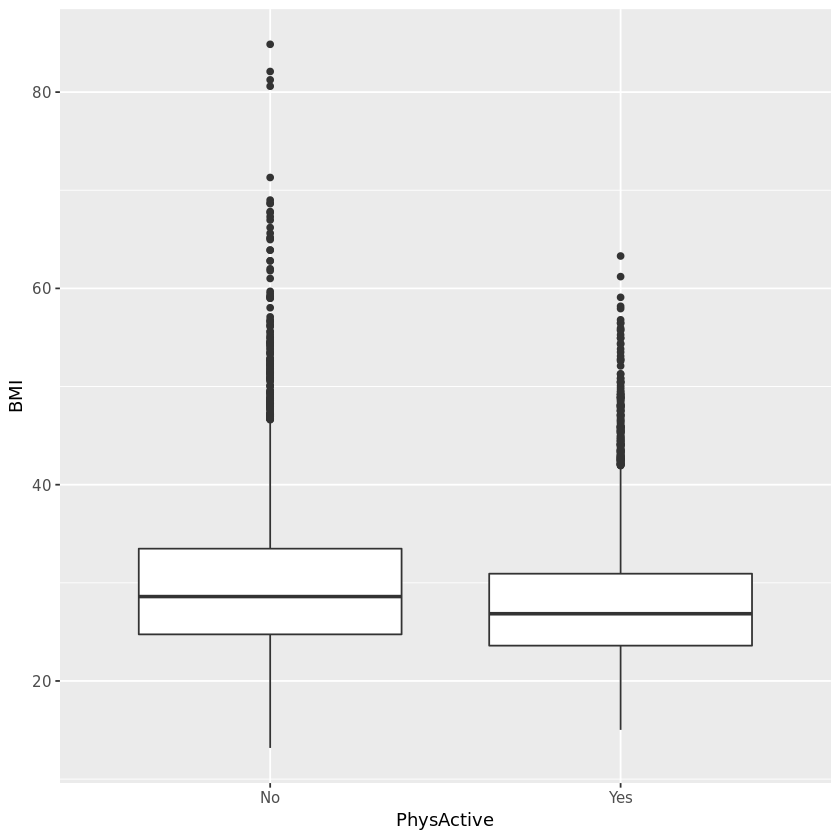

In [319]:
# Load the broom library
# .... YOUR CODE FOR TASK 6 ....
library(broom)
# Make a boxplot of BMI stratified by physically active status
NHANESraw %>% 
  filter(Age>=20) %>%
# .... YOUR CODE FOR TASK 6 ....
  ggplot(mapping = aes(PhysActive, BMI, weight = WTMEC4YR)) +
    geom_boxplot()
# Conduct a t-test comparing mean BMI between physically active status
survey_ttest <- svyttest(BMI~PhysActive, design = nhanes_adult)

# Use broom to show the tidy results
# .... YOUR CODE FOR TASK 6 ....
tidy(survey_ttest)

## 7. Could there be confounding by smoking? (part 1)
<p>The relationship between physical activity and BMI is likely not so simple as "if you exercise you will lower your BMI." In fact, many other lifestyle or demographic variables could be confounding this relationship. One such variable could be smoking status. If someone smokes, is he or she more or less likely to be physically active? Are smokers more likely to have higher or lower BMI? We can examine these relationships in the survey data. Note that many people chose not to answer the smoking question, so we reduce our sample size when looking at this data.</p>
<p>First, let's look at the relationship between smoking and physical activity.</p>

SmokeNow,PhysActiveNo,PhysActiveYes,se.PhysActiveNo,se.PhysActiveYes
No,0.4566990,0.5433010,0.01738054,0.01738054
Yes,0.5885421,0.4114579,0.01163246,0.01163246


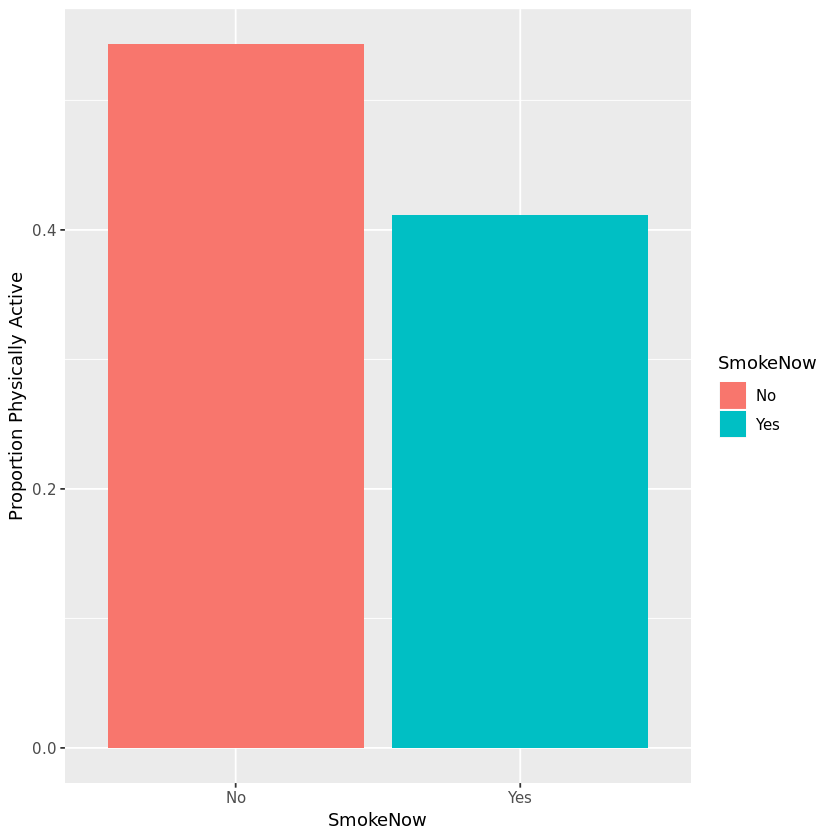

In [321]:
# Estimate the proportion who are physically active by current smoking status
phys_by_smoke <- svyby(~PhysActive, by = ~SmokeNow, 
                       FUN = svymean, 
                       design = nhanes_adult, 
                       keep.names = FALSE)

# Print the table
phys_by_smoke

# Plot the proportions
ggplot(data = phys_by_smoke, aes(y = PhysActiveYes, x = SmokeNow, fill = SmokeNow)) +
 # .... YOUR CODE FOR TASK 7 ....
geom_col() +
labs(x = "SmokeNow", y = "Proportion Physically Active")

## 8. Could there be confounding by smoking? (part 2)
<p>Now let's examine the relationship between smoking with BMI.</p>

,SmokeNow,BMI,se
No,No,29.25734,0.1915138
Yes,Yes,27.74873,0.1652377


Warning message:
"Removed 244 rows containing non-finite values (stat_boxplot)."

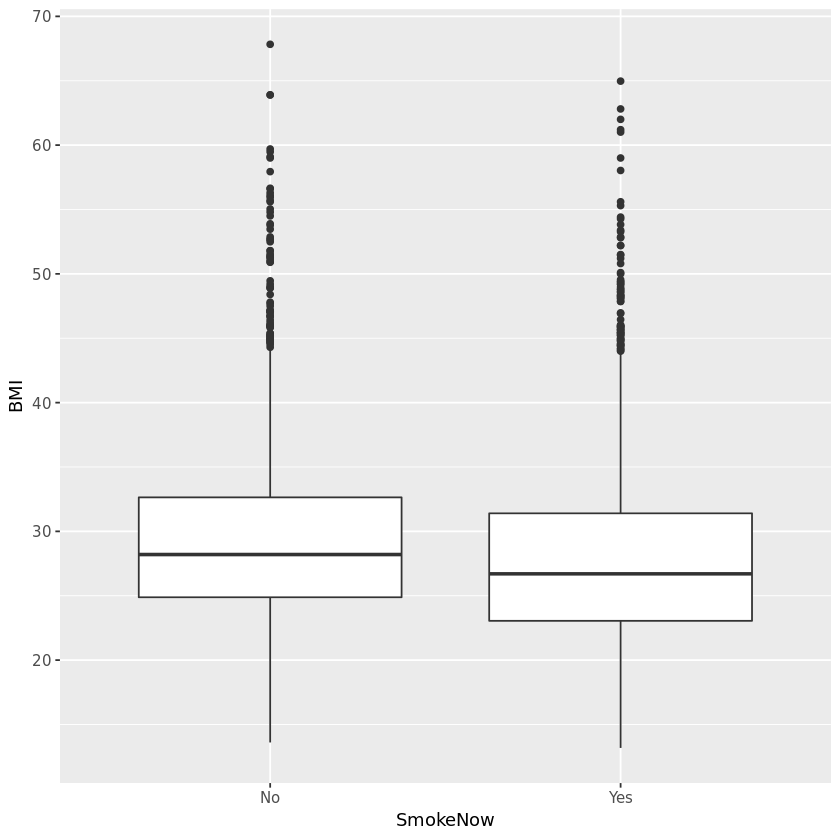

In [323]:
# Estimate mean BMI by current smoking status
BMI_by_smoke <- svyby(~BMI, by = ~SmokeNow, 
                      FUN = svymean, 
                      design = nhanes_adult,
                      na.rm = TRUE)
BMI_by_smoke

# Plot the distribution of BMI by current smoking status
NHANESraw %>% 
  filter(Age>=20, !is.na(SmokeNow)) %>% 
# .... YOUR CODE FOR TASK 8 ....
ggplot(mapping = aes(y = BMI, x = SmokeNow, weight = WTMEC4YR)) +
geom_boxplot() 

## 9. Add smoking in the mix
<p>We saw that people who smoke are less likely to be physically active and have a higher BMI on average. We also saw that people who are physically active have a lower BMI on average. How do these seemingly conflicting associations work together? To get a better sense of what's going on, we can compare BMI by physical activity stratified by smoking status.</p>

Warning message:
"Removed 547 rows containing non-finite values (stat_boxplot)."

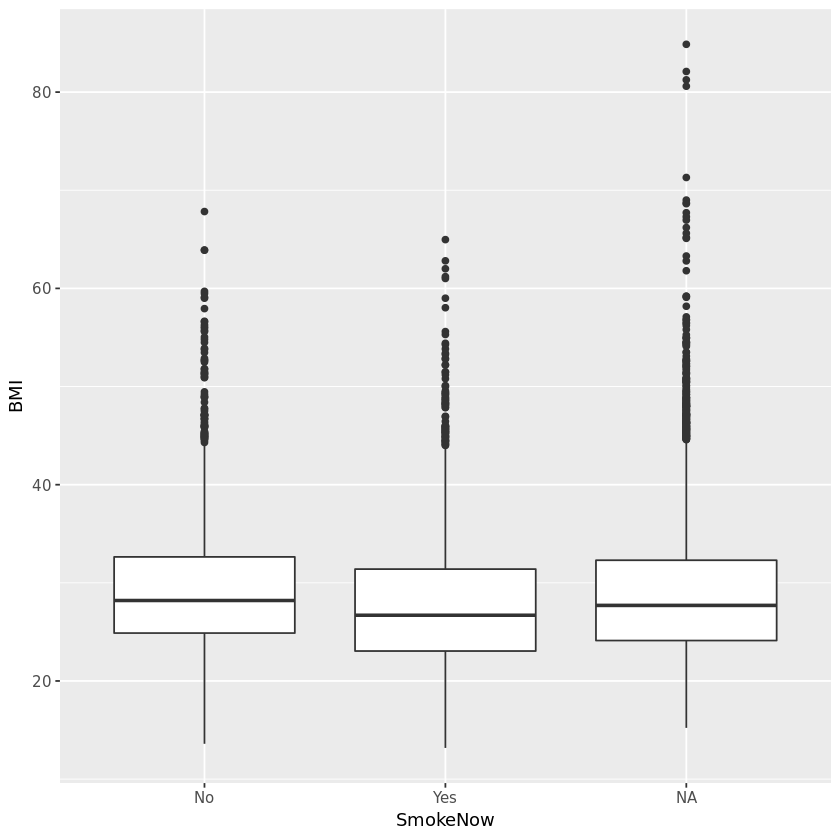

In [325]:
# Plot the distribution of BMI by smoking and physical activity status
NHANESraw %>% 
  filter(Age>=20) %>% 
# .... YOUR CODE FOR TASK 9 ....
ggplot(mapping = aes(y = BMI, x = SmokeNow, weight = WTMEC4YR)) + 
geom_boxplot()

## 10. Incorporate possible confounding in the model
<p>In the above plot, we see that people who are physically active tend to have lower BMI no matter their smoking status, and this is true even if they didn't answer the question. However, we also see that smokers have lower BMI in general. Also, looking closely we see the difference in BMI comparing physically active people to non-physically active people is slightly smaller in smokers than in non-smokers.</p>
<p>Previously, we used a simple t-test to compare mean BMI in physically active people and non-physically active people. In order to adjust for smoking status, as well as other possible confounders or predictors of BMI, we can use a linear regression model with multiple independent variables. When using survey data, we use a weighted linear regression method which is a special case of generalized linear models (GLMs).</p>

In [327]:
# Fit a multiple regression model
mod1 <- svyglm(BMI ~ PhysActive*SmokeNow, design = nhanes_adult)

# Tidy the model results
tidy_mod1 <- tidy(mod1)
tidy_mod1

# Calculate expected mean difference in BMI for activity within non-smokers
diff_non_smoke <- tidy_mod1 %>% 
    filter(term == 'PhysActiveYes') %>% 
    select(estimate)
diff_non_smoke

# Calculate expected mean difference in BMI for activity within smokers
diff_smoke <- tidy_mod1 %>% 
    filter(term %in% c('PhysActiveYes','PhysActiveYes:SmokeNowYes')) %>% 
    summarize(estimate = sum(estimate))
diff_smoke

term,estimate,std.error,statistic,p.value
(Intercept),30.540997,0.2098466,145.539656,2.619435e-44
PhysActiveYes,-2.350701,0.2358895,-9.965262,4.961177e-11
SmokeNowYes,-2.238390,0.2665632,-8.397223,2.262528e-09
PhysActiveYes:SmokeNowYes,1.004490,0.3435443,2.923903,6.520735e-03


estimate
-2.350701


estimate
-1.346211


## 11. What does it all mean?
<p>We fit a linear regression model where the association of physical activity with BMI could vary by smoking status. The interaction between physical activity and smoking has a small p-value, which suggests the association does vary by smoking status. The difference between physically active and non-physically active people is larger in magnitude in the non-smoker population.</p>
<p>We should check the <a href="https://campus.datacamp.com/courses/inference-for-linear-regression/technical-conditions-in-linear-regression?ex=1">model fit and technical assumptions</a> of our regression model. Then, we can conclude that physically active people tend to have lower BMI, as do smokers. Although they have similar effect sizes, we probably wouldn't want to recommend smoking along with exercise!</p>
<p>In order to determine whether physical activity <em>causes</em> lower BMI, we would need to use causal inference methods or a randomized control study. We can adjust for other possible confounders in our regression model to determine if physical activity is still associated with BMI, but we fall short of confirming that physical activity itself can lower one's BMI.</p>

In [329]:
# Adjust mod1 for other possible confounders
mod2 <- svyglm(BMI ~ PhysActive*SmokeNow + Race1 + Alcohol12PlusYr + Gender, 
               design = nhanes_adult)

# Tidy the output
tidy(mod2)

term,estimate,std.error,statistic,p.value
(Intercept),33.2378322,0.3162940,105.0852370,1.745688e-33
PhysActiveYes,-2.1140302,0.2729173,-7.7460482,5.559290e-08
SmokeNowYes,-2.2266832,0.3034114,-7.3388252,1.402940e-07
Race1Hispanic,-1.4670407,0.4200193,-3.4927937,1.875493e-03
Race1Mexican,-0.1909654,0.4637845,-0.4117546,6.841735e-01
Race1White,-2.0761158,0.3200810,-6.4862209,1.043842e-06
Race1Other,-3.1050466,0.6202084,-5.0064570,4.089394e-05
Alcohol12PlusYrYes,-0.8549211,0.3575930,-2.3907660,2.501002e-02
Gendermale,-0.2557363,0.2302174,-1.1108470,2.776397e-01
PhysActiveYes:SmokeNowYes,0.7368701,0.3874182,1.9020020,6.923930e-02
